# Final Project

## RecSys Twitter challenge

### Autors: Quimi, Ricard, Pere

## ÍNDEX

* 1\. [Introducció](#Intro)

* 2\. [Data Preparation & Data Preprocessing](#Data_prep)

    * 2.1\. [Data Preparation](#Data_prepa)
    
    * 2.2\. [Data Preprocessing](#Data_prepro)

* 3\. [Data Analysis (Text Analysis/Cleaning)](#Data_analysis)

    * 3.1\. [Univariate Descriptive Analysis](#Univariate_analysis)
    
        * 3.1.1\. [Numeric variables](#Numeric_descriptive)
        
        * 3.1.2\. [Categoric variables](#Categoric_descriptive)
    
    * 3.2\. [Text Analysis](#Text_analysis)
    
        * 3.2.1\. [Idioma](#Data_analysis_idioma)

        * 3.2.2\. [Tipus de twit](#Data_analysis_tipus)

        * 3.2.3\. [Text tokens: anàlisi i data cleaning](#Data_analysis_tokens)

        * 3.2.4\. [Links: enllaços, multimedia i retweets](#Data_analysis_links)

        * 3.2.5\. [Hashtags i mencions](#Data_analysis_hashtags)

        * 3.2.6\. [Observacions sobre els diferents tipus de twit ](#Data_analysis_observacions)

* 4\. [XGBoost Model](#Model)

    * 4.1\. [Model senzill](#Model_simple)

    * 4.2\. [Model amb tokens](#Model_tokens)

* 5\. [Conclusió](#Conclusió)

<a id='Intro'></a>
## 1.Introducció 

#### Objectius
Aquest projecte, destinat a l'entrega del treball de postgrau de Data Science, neix de l'oportunitat de participar en el [Recsys Challenge](https://recsys-twitter.com/) organitzat per Twitter en l'edició del 2020.

De totes maneres, enlloc de participar directament a la competició, aquest treball es centra en aprofitar les dades publicades i té els següents objectius.

* Tractament de dades: Anàlisi del dataset original, netejant i modificant algunes propietats per a poder-hi trebalar millor
* Anàlisi de dades: Processat de les dades obtingudes per a convertir-les en un format més adient per a la posterior obtenció de models de Machine Learning.
* Anàlisis del text dels tweets: Recerca sobre el model BERT en el que s'entreguen les dades de text i exploració de la naturalesa del text dels tweets proporcionat.
* Feature selection: Exploració de les variables del dataset original, o obtingudes en el processat posterior que poden donar més informació en el model de recomenació posterior.
* Model de Recomenació: Implementar un model *recommender* utilitzant la llibreria XGBoost i analitzar-ne les resultats obtinguts

Així doncs, l'objectiu principal serà el d'explorar a fons el dataset publicat i utilitzar-lo per a obtenir un model de *Recommender*

#### Obtenció de dades

Degut a que el dataset publicat per l'organització era massa gran per a poder-hi treballar amb els nostres equips, s'ha decidit agafar només una mostra del dataset original.

Enlloc d'agafar només les primeres files del dataset, s'ha optat per fer un mostreig aleatori que asseguri una mostra representaiva de tweets (publicació en diferents dies de la setmana, moments del dia, idiomes, etc.). A més a més, s'ha aprofitat per canviar el format de les dades de *.tsv* a *.csv*, per al seu tractament posterior.

A continuació es pot observar el codi utilitzat per a l'obtenció de les dades amb les que es treballaran, que seran guardades en un fitxer anomenat "tocho.csv". S'han comentat les files que només cal que siguin executades quan es vol obtenir un nou fitxer per agilitzar posteriors execucions del codi un cop obtinguda la mostra.

In [1]:
# Random sample from alarge tsv file
n = 300000000 # total number of rows (aprox)
s = 1000000 # desired sampling size

#skip = sorted(random.sample(range(1,n+1),n-s)) # filas a saltar

# print(skip)
# DESCOMENTAR SOLO PARA OBTENER NUEVAS MUESTRAS
# df = pd.read_csv(filename, skiprows=skip, delimiter='\x01', header=None)

# Columns names
all_features = ["text_tokens", "hashtags", "tweet_id", "present_media", "present_links", "present_domains",\
                "tweet_type","language", "tweet_timestamp", "engaged_with_user_id", "engaged_with_user_follower_count",\
               "engaged_with_user_following_count", "engaged_with_user_is_verified", "engaged_with_user_account_creation",\
               "engaging_user_id", "engaging_user_follower_count", "engaging_user_following_count", "engaging_user_is_verified",\
               "engaging_user_account_creation", "engagee_follows_engager","reply_timestamp","retweet_timestamp","retweet_with_comment_timestamp","like_timestamp"]
#df.columns=all_features

# Export to a csv
export_filename = 'tocho.csv'

# DESCOMENTAR SOLO PARA OBTENER NUEVAS MUESTRAS
# df.to_csv(export_filename, encoding='utf-8')

#### Explicació dataset

Les columnes del dataset original es poden trobar explicades a la web del [*challenge*](https://recsys-twitter.com), a la taula que s'ajunta a continuació:

![taula](taula.png)

En resum, podem veure que les dades e spoden classificar en 3 categories:

* Dades sobre el tweets: contingut de text, de mitjans multimèdia, hashtags, links, tipologia del Tweet (TopLevel, Retweet, Quote o Reply) i moment de publicació del Tweet.
* Dades sobre usaris de Twitter: Antiguitat de l'usuari, número de seguidors i de gent que el segueix i existència de verificació de l'usuari. Aquestes dades es donen tant per l'usuari que fa el Tweet, com pel que hi interacciona o hi reacciona
    * Dades sobre l'usuari que ha publicat el tweet
    * Dades obre la persona que ha reaccionat al tweet
* Dades sobre la interacció que s'ha produit: Moment i tipologia de la interacció (Reply, Retweet o Like), i si els usuaris es segueixen entre ells

<a id='Data_prep'></a>
## 2.Data Preparation & Data Preprocessing



Abans de res es carreguen algunes llibreries necessàries:

In [1]:
# Import needed packages
import os
import pandas as pd
import matplotlib
import numpy as np

C:\Users\usuario\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\usuario\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\usuario\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


I ara es pot obrir l'arxiu csv on es té la mostra aleatòria de Tweets i carregar les primeres files per fer-ne una exploració:

In [2]:
# set path
#libname = 'C:/Users/usuario/Documents/Data Science/Postgrau-master/Final Project'

# load data
df = pd.read_csv('twitter_subset1M.csv')

# Visualize some data
df.head()

,Unnamed: 0,text_ tokens,hashtags,tweet_id,present_media,present_links,present_domains,tweet_type,language,tweet_timestamp,...,engaging_user_id,engaging_user_follower_count,engaging_user_following_count,engaging_user_is_verified,engaging_user_account_creation,engagee_follows_engager,reply_timestamp,retweet_timestamp,retweet_with_comment_timestamp,like_timestamp
0,0,101\t16493\t12478\t117\t10105\t42370\t76299\t1...,NaN,39024FBE0136E046D1357196BAECFCA6,GIF,NaN,NaN,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581532200,...,000006829BEADA9EEA695CF0C334B426,2,29,False,1568107028,False,NaN,NaN,NaN,NaN
1,1,101\t56898\t137\t12026\t10216\t39639\t10161\t1...,NaN,885EECCFE319306E00FFFFAC9016DCAC,NaN,NaN,NaN,Retweet,06D61DCBBE938971E1EA0C38BD9B5446,1581460521,...,00003E6CE47A2F6992901FA83F253C68,1148,1038,False,1266187322,False,NaN,NaN,NaN,NaN
2,2,101\t14924\t16118\t10114\t12888\t15127\t31204\...,3653868A966576CF17D6A9064889BCED\t7A6710E791A1...,AB3ADBBD011F88D10FE7F6C5FDAB214C,Photo,NaN,NaN,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581087590,...,000269A50293CC2B1E9C72B287FA624E,515,424,False,1254588643,True,NaN,NaN,NaN,1.581090e+09
3,3,101\t138\t19826\t10108\t10105\t10635\t10105\t1...,NaN,675D7920EA2FB4869BA767F5122FB115,NaN,NaN,NaN,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581134845,...,0004C10C480EF88F3EED5822149DC93F,4,125,False,1547955941,False,NaN,NaN,NaN,1.581135e+09
4,4,101\t73714\t117\t11858\t10730\t12603\t11387\t4...,NaN,9D81B887F9DCA4C481762720A980F372,NaN,NaN,NaN,Quote,2996EB2FE8162C076D070A4C8D6532CD,1581384474,...,0007B114B09D17838F76C88A51374017,34,172,False,1561164616,False,NaN,NaN,NaN,NaN


Es poden observar varis aspectes que s'han decidit modificar per poder treballar millor amb el dataset:
* Aquelles columnes on hi ha llistes (text tokens, hashtags i present_media), els components de la llista es troben separats amb un tabulador \t
* Hi ha moltes columnes amb molts valors NaN.
* Es poden veure variables categòriques, com present media, on pot ser interessant transformar-les en varies columnes binàries (one hot encoding).

<a id='Data_prepa'></a>
### 2.1 Data Preparation

En primer lloc, es corregeix el nom d'alguna columna, per evitar futures confusions degut a un espai extra

In [3]:
# Rename 'text_tokens' column name
df.rename(columns={'text_ tokens':'text_tokens'}, inplace=True)

Per poder fer un estudi dels token més entenedor, es selecciona només un subset de tweets en anglès, en un primer moment (idioma amb més tweets).

In [4]:
# Look for the language with more tweets:
df.language.value_counts()

# Select tweets in English
#df = df[df.language=='D3164C7FBCF2565DDF915B1B3AEFB1DC']

D3164C7FBCF2565DDF915B1B3AEFB1DC    190801
22C448FF81263D4BAF2A176145EE9EAD     72132
06D61DCBBE938971E1EA0C38BD9B5446     41662
ECED8A16BE2A5E8871FD55F4842F16B1     30583
B9175601E87101A984A50F8A62A1C374     24217
4DC22C3F31C5C43721E6B5815A595ED6     14886
167115458A0DBDFF7E9C0C53A83BAC9B     14162
022EC308651FACB02794A8147AEE1B78     10287
FA3F382BC409C271E3D6EAF8BE4648DD     10137
125C57F4FA6D4E110983FB11B52EFD4E     10051
9BF3403E0EB7EA8A256DA9019C0B0716      7906
975B38F44D65EE42A547283787FF5A21      4370
2996EB2FE8162C076D070A4C8D6532CD      3786
3820C29CBCA409A33BADF68852057C4A      2403
717293301FE296B0B61950D041485825      2320
3E16B11B7ADE3A22DDFC4423FBCEAD5D      2186
FF60A88F53E63000266F8B9149E35AD9      2054
76B8A9C3013AE6414A3E6012413CDC3B      1236
9ECD42BC079C20F156F53CB3B99E600E      1165
AEF22666801F0A5846D853B9CEB2E327      1133
190BA7DA361BC06BC1D7E824C378064D      1053
1FFD2FE4297F5E70EBC6C3230D95CB9C       834
48236EC80FDDDFADE99420ABC9210DDF       717
A0C7021AD82

Es corregeix la llista de tokens separda per tabuladors, per una llista de tokens, i s'elimina la primera columna que no aporta informació:

In [5]:
# Clean tokens and transform into lists
df['text_tokens'] = df['text_tokens'].str.split('\t')

# Remove first column
df.drop('Unnamed: 0', axis=1, inplace=True)

En aquets punt, es decideix que donada la potència de càlcul disponible i la mida limitada de la mostra actual, no es faran servir els IDs dels tweets o dels usuaris com a *features* en els futus models i s'eliminen del dataset:

In [6]:
# Remove id variables
#df.drop(['tweet_id', 'engaged_with_user_id', 'engaging_user_id'], axis=1, inplace=True)

Es simplifiquen, en un primer moment, totes les possibles interaccions per una sola columna que indicarà, en el cas que hi hagi hagut interacció, el moment de la que es va produir en primer lloc. 

Amb aquestes dades, també es crea una nova columna que indicarà si hi ha ahgut interacció o no (fals positiu en el dataset). D'aquesta manera, en aquelles columnes on el *engagement_timestamp* sigui un NaN, es posarà un 0 (no ha existit interacció), i si hi ha un valor numèric, se li assigna un 1 (existeix interacció).

In [7]:
# Add variable 'engagement_timestamp' and remove timestamp columns
df['engagement_timestamp'] = df[['reply_timestamp','retweet_with_comment_timestamp','like_timestamp']].min(axis=1)
df.drop(['reply_timestamp', 'retweet_timestamp', 'retweet_with_comment_timestamp', 'like_timestamp'], axis=1, inplace=True)

# Add variable 'engagement_exists'
df['engagement_exists'] = df['engagement_timestamp'].apply(lambda x: 0 if (np.isnan(x)) else 1)

Es pot observar, que en relació a aquesta última característica, el dataset està bastant balancejat

In [8]:
df.engagement_exists.value_counts()

0    247144
1    208374
Name: engagement_exists, dtype: int64

Per últim, s'eliminen les columnes que ja no es fan servir per simplificar el *DataFrame* i es corregeix l'índex

In [9]:
# Remove unused variables
#df.drop(['present_domains', 'language'], axis=1, inplace=True)

# Upload index
df.reset_index(drop=True, inplace=True)

<a id='Data_prepro'></a>
### 2.2 Data Preprocessing

Amb un *DataFrame* més endreçat i net, es comencen a processar les dades per obtenir nous valors o modificar el fromat d'algunes columnes per a que siguin més adients per a ser introduides en un futur model.

Per a les columnes amb els hashtags i els links codifictas, es creen dues columnes binàries que indiquen l'existència o no d'un hashtag o un link en cada tweet

In [10]:
# Transform variable 'hashtags' to boolean one-hot encoded
df['present_hashtags'] = df['hashtags'].apply(lambda x: 1 if not pd.isnull(x) else 0)
df.drop('hashtags', axis=1, inplace=True)

# Transform variable 'present_links' to boolean one-hot encoded
df['present_links'] = df['present_links'].apply(lambda x: 1 if not pd.isnull(x) else 0)

En el cas de la variable present media, aquesta pot tenir diferents valors en funció de la tipologia de contingut multimèdia en un tweet, o de la quantitat d'arxius que s'hi poden trobar. Per la mostra actual, per exemple, es poden trobar:

In [11]:
 df['present_media'].unique()

array(['GIF', nan, 'Photo', 'Video', 'Photo\tPhoto',
       'Photo\tPhoto\tPhoto\tPhoto', 'Photo\tPhoto\tPhoto',
       'Video\tVideo', 'Photo\tVideo', 'Video\tPhoto'], dtype=object)

Per aquets motiu, es decideix crear 3 columnes (Poto, Video i GIF), on es mostra la quantita d'arxius que hi ha en cada tweet separat per la tipologia d'arxiu multimèdia.

In [12]:
# Transform variable 'present_media' into 3 new variables one-hot encoded
def hot_encod_photo(x):
    try:
        return x.count('Photo')
    except AttributeError:
        return 0
def hot_encod_video(x):
    try:
        return x.count('Video')
    except AttributeError:
        return 0
def hot_encod_gif(x):
    try:
        return x.count('GIF')
    except AttributeError:
        return 0
    
df['present_photo'] = df['present_media'].apply(hot_encod_photo)
df['present_video'] = df['present_media'].apply(hot_encod_video)
df['present_gif'] = df['present_media'].apply(hot_encod_gif)

#df.drop(['present_media'], axis=1, inplace=True)

Es continua fent un one-hot encoding en variables com el tipus de tweet, o en d'altres que ja són binàries pero no tenene el format correcte

In [13]:
# Transform 'tweet_type' variable to one-hot encoded
dummies_tweet_type = pd.get_dummies(df['tweet_type'])
df = pd.concat([df, dummies_tweet_type], axis=1)
#df.drop(['tweet_type'], axis=1, inplace=True)

# Transform boolean variables to one-hot encoded
df["engaged_with_user_is_verified"] = df["engaged_with_user_is_verified"].astype(int)
df["engaging_user_is_verified"] = df["engaging_user_is_verified"].astype(int)
df["engagee_follows_engager"] = df["engagee_follows_engager"].astype(int)

Pel que fa a les columnes que mostren variables temporals, es realitzen les següents accions:
1. Es posen totes en format *datetime* per poder-hi treballar millor
2. Es crea una variable que mesura el temps entre el tweet origen i la reacció si aquesta existeix (*reaction time*)
3. S'afegeix una variable que mesura el moment del dia en que s'ha publicat el tweet, podent prendre 3 valors diferennts en funció del moment del dia (matí, tarda i vespre).
4. S'eliminen les columnes de *tweet_timestamp* i *engagement_timestamp*, ja no utilitzades

In [14]:
# Transform timestamp variables to readable dates
df['tweet_timestamp'] = pd.to_datetime(df['tweet_timestamp'], unit='s')
df['engagement_timestamp'] = pd.to_datetime(df['engagement_timestamp'], unit='s')
df['engaged_with_user_account_creation'] = pd.to_datetime(df['engaged_with_user_account_creation'], unit='s')
df['engaging_user_account_creation'] = pd.to_datetime(df['engaging_user_account_creation'], unit='s')

# Create new variable 'reaction_time'
df['reaction_time'] = df['engagement_timestamp'] - df['tweet_timestamp']
df['reaction_time'] = df['reaction_time'].dt.total_seconds()

# Create new variable 'time_of_day'
tweet_hour = df.tweet_timestamp.dt.hour
bin = [0,8,16,24] 
category = pd.cut(tweet_hour, bin, include_lowest=True, labels=['morning','afternoon','evening'])
df = pd.concat([df, pd.get_dummies(category)], axis=1)

# Create new variable 'day_of_week'
tweet_day = df.tweet_timestamp.dt.weekday
df_tweet_day = pd.get_dummies(tweet_day)
df_tweet_day.rename({0:'monday',1:'tuesday',2:'wednesday', 3:'thursday', 4:'friday', 5:'saturday', 6:'sunday'}, axis='columns', inplace=True)
df = pd.concat([df, df_tweet_day], axis=1)

# Remove variable 'tweet_timestamp'
df.drop(['tweet_timestamp'], axis=1, inplace=True)
df.drop(['engagement_timestamp'], axis=1, inplace=True)

Per a poder tenir més informació respecte els usuaris, tant els que fan els tweets com els que hi reaccionen, es comptabilitza el número de dies d'antiguitat dels seus comptes des de la seva creació fins avui. Es podria fer el mateix, agafant entre el moment de la creació dels comptes i el la publicació del tweet, però al ser tot el dataset de tweets en una mateixa setmana s'aconseguirien resultas molt semblants

In [15]:
# Create new variable 'engaged_with_user_account_days'
from datetime import date
user_days = (pd.Timestamp.now() - df.engaged_with_user_account_creation).dt.days
user_days.name = 'engaged_with_user_account_days'
df = pd.concat([df, pd.Series(user_days)], axis=1)
df.drop(['engaged_with_user_account_creation'], axis=1, inplace=True)

# Create new variable 'engaging_user_account_days'
from datetime import date
user_days = (pd.Timestamp.now() - df.engaging_user_account_creation).dt.days
user_days.name = 'engaging_user_account_days'
df = pd.concat([df, pd.Series(user_days)], axis=1)
df.drop(['engaging_user_account_creation'], axis=1, inplace=True)

En el cas de l'usuari que crea el tweet, es decideix crear una variable que també mostri com de popular és. Per això, es tene en compte dues coses:
* La ratio entre followers i following: s'agafa el percentil del 25% amb gen amb una ratio més gran de gent amb més followers per cada following.
* La quantitat de followers que té l'usuari, ha d'estar per sobre la mediana dels usuaris del dataset amb el que es treballa.

In [16]:
# Create new variable 'engaged_with_user_popular'

ratio_follows = df.engaged_with_user_following_count/df.engaged_with_user_follower_count

ratio_popular = ratio_follows <= np.percentile(ratio_follows, 25)
follower_popular = df.engaged_with_user_follower_count >= df.engaged_with_user_follower_count.median()

engaged_with_user_popular = pd.Series(ratio_popular & follower_popular, name = 'engaged_with_user_popular').astype(int)
df = pd.concat([df, engaged_with_user_popular], axis=1)

-------------------------------------------------------------------------------------------------------------------------------

<a id='Data_analysis'></a>

## 3.Data Analysis

En aquest apartat ens centrem en l'anàlisi del dataset a partir del text i les columnes que hi mantenen una relació amb aquest. A més, crearem algunes columnes extra per facilitar la lectura i l'accès a les dades de valor del text, així com poden ser els enllaços o els hashtags.

Entendre el tipus de dades amb les que estem tractan és bàsic per poder conformar un correcte sistema de recomanació. Com l'activitat principal dels usuaris de Twitter és publicar i llegir publicacions, ens va semblar lògic començar a observar el nostre dataset pel text d'aquestes publicacions. 

Tal i com diu la introducció del [RecSys Challenge](https://recsys-twitter.com/):

> Twitter is what’s happening in the world and what people are talking about right now. On Twitter, live comes to life as conversations unfold, showing you all sides of the story. From breaking news and entertainment to sports, politics and everyday interests, when things happen in the world, they happen first on Twitter.

El primer pas que vam haver de donar de cara a desxifrar què i com s'estava dient a les publicaciones amb les que anavem a treballar va ser entendre el model [BERT](https://arxiv.org/abs/1810.04805). 

Les dades de text del nostre dataset es presenten tal i com es descriu a la taula a la [introducció](#Intro):

> Ordered list of Bert ids corresponding to Bert tokenization of Tweet text

Aquesta tokenització s'obté a partir d'un transformador multilingüe basat en un model de representació bidireccional (BERT: *Bidirectional Encoder Representations from Transformers*). 

Presentat al 2019, i per tant un model state-of-the-art en l'àmbit de NLP, aquest model està dissenyat per obtenir el contexte esquerre i dret (*bidirectional*) de totes les capes. 

> BERT is conceptually simple and empirically powerful. It obtains new state-of-the-art results on eleven natural language processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQuAD v1.1 question answering Test F1 to 93.2 (1.5 point absolute improvement) and SQuAD v2.0 Test F1 to 83.1 (5.1 point absolute improvement).

En concret, el model BERT que hem fet servir és el [BERT Base Multilingual Cased](https://huggingface.co/bert-base-multilingual-cased), un model pre-entrenat amb els articles de les 104 llengües amb més entrades a la Wikipedia, fent servir un procès anomenat masked language modeling (MLM) i, que com el seu propi nom indica, és sensible als caracters en majúscules/minúscules (*cased*).

> BERT-Base, Multilingual Cased: 104 languages, 12-layer, 768-hidden, 12-heads, 110M parameters



A continuació es mostra per una banda un anàlisi descriptiu univariant de les variables ordinàries (numèriques i categòriques) que hi ha a la taula de dades, i per altra banda un anàlisi en profunditat del text dels tuits decodificats a partir dels tokens.

<a id='Univariate_analysis'></a>

### 3.1 Univariate Descriptive Analysis

Per dur a terme un anàlisi de les variables que hi ha al model s'utilitzaran els estadístics descriptius més comuns per a les variables numèriques i una taula de freqüències per a les variables categòriques, per tal de poder entendre millor el comportament de les dades.

<a id='Numeric_descriptive'></a>
#### 3.1.1 Numeric variables 

In [17]:
numeric_cols = ['engaged_with_user_follower_count', 'engaged_with_user_following_count', 'engaging_user_follower_count',
                    'engaging_user_following_count', 'engaged_with_user_account_days', 'engaging_user_account_days',
               'reaction_time']

[print(round(df[col].describe(),0), '\n------------------------------------') for col in numeric_cols]

count       455518.0
mean       1408510.0
std        6943138.0
min              1.0
25%           1241.0
50%          15068.0
75%         216375.0
max      112787050.0
Name: engaged_with_user_follower_count, dtype: float64 
------------------------------------
count     455518.0
mean        5544.0
std        47164.0
min            0.0
25%          197.0
50%          545.0
75%         1452.0
max      4447036.0
Name: engaged_with_user_following_count, dtype: float64 
------------------------------------
count     455518.0
mean         856.0
std        19483.0
min            0.0
25%           41.0
50%          155.0
75%          462.0
max      5189088.0
Name: engaging_user_follower_count, dtype: float64 
------------------------------------
count    455518.0
mean        616.0
std        1869.0
min           1.0
25%         127.0
50%         282.0
75%         608.0
max      372575.0
Name: engaging_user_following_count, dtype: float64 
------------------------------------
count    455518.0


[None, None, None, None, None, None, None]

Els aspectes més rellevants a comentar dels estadístics descriptius de les variables numèriques són:
- El nombre de persones que segueixen a l'usuari que publica el tuit original és molt més alt que el nombre de persones que aquest usuari segueix (ràtio de medianes de 0.03 aproximadament).
- El nombre de persones que segueixen a l'usuari que reacciona al tuit és lleugerament més alt que el nombre de persones que aquest usuari segueix (ràtio de medianes de 0.55 aproximadament).
- Els usuaris que publiquen el tuit original acostumen a ser més antics que els usuaris que reaccionen al tuit (mediana de 2417 i 1425 dies, respectivament). 
- La distribució de la variable 'reaction_time' és molt desbalancejada, donant a entendre que hi ha algunes reaccions a tuits que fa molt temps que s'han publicat (mediana de 3 hores i mitjana de 11 hores, aproximadament).

<a id='Categoric_descriptive'></a>
#### 3.1.1 Categoric variables 

In [18]:
boolean_cols = ['present_photo', 'present_video', 'present_gif', 'present_links', 'tweet_type', 'engaged_with_user_is_verified',
               'engaging_user_is_verified', 'engagee_follows_engager', 'engagement_exists', 'present_hashtags', 
               'morning', 'afternoon', 'evening', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday',
               'engaged_with_user_popular']

[print(round(df[col].value_counts(normalize=True),2), '\n------------------------------------') for col in boolean_cols]

0    0.74
1    0.18
2    0.04
4    0.02
3    0.01
Name: present_photo, dtype: float64 
------------------------------------
0    0.89
1    0.11
2    0.00
Name: present_video, dtype: float64 
------------------------------------
0    0.99
1    0.01
Name: present_gif, dtype: float64 
------------------------------------
0    0.86
1    0.14
Name: present_links, dtype: float64 
------------------------------------
TopLevel    0.57
Retweet     0.34
Quote       0.09
Name: tweet_type, dtype: float64 
------------------------------------
0    0.74
1    0.26
Name: engaged_with_user_is_verified, dtype: float64 
------------------------------------
0    1.0
1    0.0
Name: engaging_user_is_verified, dtype: float64 
------------------------------------
0    0.65
1    0.35
Name: engagee_follows_engager, dtype: float64 
------------------------------------
0    0.54
1    0.46
Name: engagement_exists, dtype: float64 
------------------------------------
0    0.8
1    0.2
Name: present_hashtags, dtype:

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

Tal i com s'observa en les taules de freqüències de les variables categòriques, hi ha algunes variables bastant desbalancejades. Les observacions més rellevants són:
- Hi ha un 74% de tuits que no tenen cap arxiu multimèdia (foto, video o gif) i el 14% de tuits tenen també un link inclòs.
- La gran majoria de registres de la taula de dades estan catalogats com a 'TopLevel' (57%), mentre que el tipus de tuit 'Quote' només representa el 0.09% de tots els registres.
- Tots els usuaris de la taula de dades que reaccionen als tuits originals no estàn verificats, en canvi, el 25% dels usuaris del tuit original si ho estàn.
- El 35% dels usuaris que reaccionen al tuit original segueixen també a l'usuari que publica el tuit.
- Hi ha un repartiment balancejat de tuits tant pel moment del dia com per el dia de la setmana.

<a id='Text_analysis'></a>

### 3.2 Text Analysis

<a id='Data_analysis_idioma'></a>
#### 3.2.1 Idioma 

In [18]:
print(df['text_tokens'].iloc[0])

['101', '16493', '12478', '117', '10105', '42370', '76299', '100', '187', '15480', '10108', '23837', '117', '10393', '169', '32342', '18077', '10135', '10226', '27925', '10111', '10393', '17087', '10950', '10114', '41904', '51937', '16981', '10142', '15217', '119', '14820', '10689', '17860', '169', '28502', '11360', '10689', '13461', '10105', '13451', '35688', '26981', '10142', '12557', '136', '14120', '131', '120', '120', '188', '119', '11170', '120', '175', '11166', '15705', '10129', '19282', '10113', '11396', '10362', '102']


Volem identificar l'idioma dels twits, codificats en [BERT Base Multilingual Cased](https://huggingface.co/bert-base-multilingual-cased). Com els valor de la columna language estan codificats, volem inspeccionar el contingut dels textos per trobar els twits escrits en llengües que poguem interpretar. 

Per això decodifiquem el text d'un twit per valor de `language` i llegim el seu contingut. Farem servir la lliberia *transformers*:

In [19]:
#Import of the BertTokenizer module to detokenize the text tokens
from transformers import BertTokenizer

#Setting the BERT Base Multilingual Cased tokenizer model
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

#Print the first tweet in the most frequent languages
for index in df.language.value_counts().index[:21]:
    dl = df[df.language == index].copy()
    dl = dl.reset_index(drop=True)
    print("language = {} \n".format(index))        
    print(tokenizer.decode(dl['text_tokens'].iloc[0]) + '\n')

language = D3164C7FBCF2565DDF915B1B3AEFB1DC 

[CLS] Jacob Young, the Syndicate [UNK] s Director of PR, has a serious problem on his hands and has reached out to Hammond Robotics for help. Can they find a solution before they become the next ones marked for death? https : / / t. co / g5evrQa8va [SEP]

language = 22C448FF81263D4BAF2A176145EE9EAD 

[CLS] ただいま うさ 顔 洗 い 中. おしっこ 飛 ばしの 後 にはいつもする 仕 草. 壁 跡 は 生 々しいけれど 、 なんとも 愛 らしい [UNK] [UNK] ！.. # うさぎ # うさぎ 好 きさんと 繋 がりたい # 顔 洗 い # キリトリセカイ # 癒 し 動 画 # 動 物 好 きな 人 と 繋 がりたい # うさぎあるある # 動 物 あるある # ファインダー 越 しの 私 の 世 界 # 部 屋 んぽ # かわいい https : / / t. co / 2gKb0EeWqa [SEP]

language = 06D61DCBBE938971E1EA0C38BD9B5446 

[CLS] RT @ GermantequilIa : otra vez Las Palmas hacia ruta 68 pista izquierda bloqueada por choque de vehículo @ sitiodelsuceso @ AlertaVR https : / / t. [UNK] [SEP]

language = ECED8A16BE2A5E8871FD55F4842F16B1 

[CLS] Porque ele matou, esquartejou e deu os restos mortais da mãe do filho dele para os cachorros só pq não queria pagar pensã

De cara a l'anàlisi textual dels twits, només hem inclòs aquells en **anglès**, **castellà** i **català** filtrant mitjançant els codis corresponents als textos que hem identificat.

Per tant, només farem servir els languages `D3164C7FBCF2565DDF915B1B3AEFB1DC` (anglès), `06D61DCBBE938971E1EA0C38BD9B5446` (castellà) i `190BA7DA361BC06BC1D7E824C378064D` (català).

In [20]:
#Subset: English language 
language = 'D3164C7FBCF2565DDF915B1B3AEFB1DC'
d_eng = df[df.language == language].copy()
d_eng = d_eng.reset_index(drop=True)

#Subset: Spanish language 
language = '06D61DCBBE938971E1EA0C38BD9B5446'
d_cast = df[df.language == language].copy()
d_cast = d_cast.reset_index(drop=True)

#Subset: Catalan language 
language = '190BA7DA361BC06BC1D7E824C378064D'
d_cat = df[df.language == language].copy()
d_cat = d_cat.reset_index(drop=True)

print("English subset has a total of {} twits".format(d_eng.size))
print("Spanish subset has a total of {} twits".format(d_cast.size))
print("Catalan subset has a total of {} twits".format(d_cat.size))

English subset has a total of 7250438 twits
Spanish subset has a total of 1583156 twits
Catalan subset has a total of 40014 twits


<a id='Data_analysis_tipus'></a>
#### 3.2.2 Tipus de twit

Una vegada filtrats els twits per idioma, parem atenció als tipus de twit:

In [21]:
d_eng['tweet_type'].value_counts()

TopLevel    99974
Retweet     72282
Quote       18545
Name: tweet_type, dtype: int64

Tenim tres tipus de twits:
- <b>TopLevel</b>: Twit publicat originalment per un usuari
- <b>Retweet</b>: Twit compartit per un usuari, però publicat originalment per un altre usuari
- <b>Quote</b>: Resposta d'un usuari a un TopLevel ó Retweet

Amb la intenció d'identificar contingut original per usuari, descartem els Retweets. 

In [22]:
engagement_user_type = 'engaged_with_user_id'
tweet_type = 'TopLevel'
d_eng_top_level = d_eng.loc[d_eng['tweet_type'] == tweet_type]

Així doncs, podem obtenir els usuaris amb més publicacions originals (TopLevel) de cada idioma.

In [23]:
d_eng_top_level[engagement_user_type].value_counts()[:10]

C6758D692A850E4C67B2763B66D1CFA8    659
5FF622786FB4924A067BD44D4B717570    509
E5D1B83B0E02FAFF871EEEF276D18132    395
7C03844E8B2E0C7B4346D41028AB14E2    328
FBB188A3C1E05C41587AAAC00B5B1879    232
F2A8BF0F4EB185E6D2E5E1A0DF4C33AE    204
416B919C0DAA48D42FF6780574034149    189
8A800256378089EF53C6F655F8690490    183
A9DAB08351D94BDE86235B37D6E8C61D    182
9D9C2BC354011249F2D4D9B9C4205AC9    168
Name: engaged_with_user_id, dtype: int64

Pel primer anàlisi, farem servir l'usuari més 'actiu' en anglès. 

In [24]:
#Take the user ID with most publications
engaging_user_id = d_eng_top_level[engagement_user_type].value_counts().index[0]

#Subset with only the twits of the user ID with most publications
d_eng_user = d_eng_top_level.loc[d_eng[engagement_user_type] == engaging_user_id]

Per tenir una idea del tipus d'usuari que hem obtingut, podem fer una ullada als seus 10 primers twits. 

In [25]:
for n in range (10): print(tokenizer.decode(d_eng_user['text_tokens'].iloc[n]))

[CLS] Why didn [UNK] t John Bolton complain about this [UNK] nonsense [UNK] a long time ago, when he was very publicly terminated. He said, not that it matters, NOTHING! [SEP]
[CLS] [UNK] I like President Trump [UNK] s Tweets ( Social Media ), I like everything about him... and this Ukraine stuff, the trial, the impeachment, this isn [UNK] t t about Ukraine. Donald Trump has committed the two unpardonable sins in the eyes of the Democrats. He beat Hillary Clinton in 2016, and.. [SEP]
[CLS] Are you better off now than you were three years ago? Almost everyone say YES! [SEP]
[CLS] Reports are that basketball great Kobe Bryant and three others have been killed in a helicopter crash in California. That is terrible news! [SEP]
[CLS] The Democrat controlled House never even asked John Bolton to testify. It is up to them, not up to the Senate! [SEP]
[CLS]..... So, what the hell has happened to @ FoxNews. Only I know! Chris Wallace and others should be on Fake News CNN or MSDNC. How [UNK] s Sh

Podem veure que és un usuari de caire polític, molt segurament nord-americà. 

<a id='Data_analysis_tokens'></a>
#### 3.2.3 Text tokens: anàlisi i data cleaning

Per poder entendre millor el model amb el que codifiquem i decodifiquem el text al nostre dataset, hem cregut oportú buscar si hi ha cap tipus d'ordre entre els tokens d'aquest. 

Imprimim els primers tokens del model per veure si es segueix algun ordre en la descripció de tokens. 

In [26]:
n = 1000
print(tokenizer.decode(x for x in range(0,n)))

[PAD] [unused1] [unused2] [unused3] [unused4] [unused5] [unused6] [unused7] [unused8] [unused9] [unused10] [unused11] [unused12] [unused13] [unused14] [unused15] [unused16] [unused17] [unused18] [unused19] [unused20] [unused21] [unused22] [unused23] [unused24] [unused25] [unused26] [unused27] [unused28] [unused29] [unused30] [unused31] [unused32] [unused33] [unused34] [unused35] [unused36] [unused37] [unused38] [unused39] [unused40] [unused41] [unused42] [unused43] [unused44] [unused45] [unused46] [unused47] [unused48] [unused49] [unused50] [unused51] [unused52] [unused53] [unused54] [unused55] [unused56] [unused57] [unused58] [unused59] [unused60] [unused61] [unused62] [unused63] [unused64] [unused65] [unused66] [unused67] [unused68] [unused69] [unused70] [unused71] [unused72] [unused73] [unused74] [unused75] [unused76] [unused77] [unused78] [unused79] [unused80] [unused81] [unused82] [unused83] [unused84] [unused85] [unused86] [unused87] [unused88] [unused89] [unused90] [unused91] [u

Veiem que els primers 105 tokens estan reservats per codis . Després s'assignen els tokens posteriors a  signes de puntuació i números. Desprès es codifiquen els distints alfabets que s'inclouen al model. 

Per un altre costat, analiztant tokens més endavant, podem veure que si a cada paraula reconeguda pel model, se li assignarà un token propi.

In [27]:
print(tokenizer.decode(x for x in range(11000,11200)))

33 годинеן three 1948 fuů invånaream kvadratkilometerou4 Earthä anche benот 1942는 made англria కి yeov 00 1957 người 1930 1920il used 1954mo dhe 09 vomwa Unjo sebagai formaésicabe Seion durante przez suchного deux 08 known ved 36 South ta nie then он USAken 1946 dass You Mariaina να 34 final 1955 से である Leagueной کی populationпраland का 1938lla than nuب 1953ine naamTسный 300 IV 1949 Thomas 1918 India τον 1952 All한 הוא State merupakanскойunні Oxford familie club July 1947 یکzione més elle Richardche June team Az 1936 unter học 44Pরneric care secondł zen ca mga Nel として Retrievedok відigth Marchو inomnuш She που には someada Santa there olehste GeoNamesut British pe Film ke West data5 gli areaán co 38 һәм 1937ció born 400 kao any became τωνdos vớitonского serie एक ook છેque vorку place Berlinныеty soorttes includingে


#### Text cleaning

Si bé la resta de columnes del nostre dataset per ara seran tractades en altre moment i secció, el procés de neteja de les dades de text l'hem portat a terme a la par que l'anàlisi del text, tant tokenitzat com decodificat. 

Podem veure al text que es repeteixen uns codis a l'inici (`[CLS]`) i final (`[SEP]`) de cada twit. De cara al procès de data cleaning, ens interessaria eliminar aquests codis. Aprofitarem també per eliminar qualsevol possible aparició d'altres tokens que no aportaran valor al text: `[PAD]` i `[MASK]`. 

In [28]:
num_tokens = [0, 101, 102, 103]

for x in num_tokens:
    print('{}: {}'.format(x, tokenizer.decode(x)))

0: [ P A D ]
101: [ C L S ]
102: [ S E P ]
103: [ M A S K ]


Una vegada identificat el token per cadascun d'aquets codis, procedim a eliminar-los del nostre dataset.

In [29]:
#Convert the token list to string items
num_tokens = [ str(x) for x in num_tokens ]

#Remove all the items in num_tokens in each tweet
for k in range(len(d_eng['text_tokens'])):
    for r in num_tokens:
        if r in d_eng['text_tokens'][k]:
            d_eng['text_tokens'][k].remove(r)

Podem veure la diferència imprimint els mateixos twits de l'usuari més actiu.

In [30]:
d_eng_top_level = d_eng.loc[d_eng['tweet_type'] == tweet_type]
engaging_user_id = d_eng_top_level[engagement_user_type].value_counts().index[0]
d_eng_user = d_eng_top_level.loc[d_eng[engagement_user_type] == engaging_user_id]

for n in range (10): print(tokenizer.decode(d_eng_user['text_tokens'].iloc[n]))

Why didn [UNK] t John Bolton complain about this [UNK] nonsense [UNK] a long time ago, when he was very publicly terminated. He said, not that it matters, NOTHING!
[UNK] I like President Trump [UNK] s Tweets ( Social Media ), I like everything about him... and this Ukraine stuff, the trial, the impeachment, this isn [UNK] t t about Ukraine. Donald Trump has committed the two unpardonable sins in the eyes of the Democrats. He beat Hillary Clinton in 2016, and..
Are you better off now than you were three years ago? Almost everyone say YES!
Reports are that basketball great Kobe Bryant and three others have been killed in a helicopter crash in California. That is terrible news!
The Democrat controlled House never even asked John Bolton to testify. It is up to them, not up to the Senate!
..... So, what the hell has happened to @ FoxNews. Only I know! Chris Wallace and others should be on Fake News CNN or MSDNC. How [UNK] s Shep Smith doing? Watch, this will be the beginning of the end for 

<a id='Data_analysis_links'></a>
#### 3.2.4 Links: enllaços, multimedia i retweets


#### Accès als links

Per poder entendre amb més detall els twits, hem cregut necessari analitzar també els enllaços que s'hi publiquen en aquests. Malauradament, la decodificació dels tokens relatius als links resulta en les distintes parts de l'enllaç separades per un espai. 

Amb la idea de fer-los *clickables*, i així més fàcil d'accedir, reconstruirem els links a partir de les parts.

In [31]:
import re

#We are looking for patterns such as https : / / t. co / yvMa6bPqfy
valid_pattern = 'https : \/ \/ t\. co \/ [\dA-Za-z\.-]+'

Farem servir regex per identificar tots els patrons que corresponguin als links presents al text. Aprofitarem també per a guardar una columna amb el text decodificat.

Guardarem també els links en una columna apart, de manera que poguem accedir-hi independentment.

In [32]:
#Create a new column to store the list of links
d_eng['present_links_url'] = ""

#Now that the text will be more readable, we will create a column with the text
d_eng['text'] = ""    

for index, row in d_eng.iterrows():
    links_list = []
    links_list_clean = []
    tweet_text = tokenizer.decode(d_eng['text_tokens'][index])
    links_list = re.findall(valid_pattern, tweet_text)
    
    for i, s in enumerate(links_list):
        if i != 0:
            tweet_text = tweet_text_replaced
        link_old = s
        link_new = s.replace(' ','') # I use replace because s.strip() is not working
        links_list_clean.append(link_new)
        tweet_text_replaced = tweet_text.replace(link_old, link_new)
    
    d_eng.at[index, 'present_links_url'] = links_list_clean
    
    if links_list == []:    
        d_eng.at[index, 'text'] = tweet_text
    else:
        d_eng.at[index, 'text'] = tweet_text_replaced

Per tal de agrupar totes les característiques textuals, reorganitzem les columnes del dataset.

In [33]:
second_col = d_eng['text']
d_eng.drop(labels=['text'], axis=1, inplace = True)
d_eng.insert(1, 'text', second_col)
d_eng.head()

col = d_eng['present_links_url']
d_eng.drop(labels=['present_links_url'], axis=1, inplace = True)
d_eng.insert(4, 'present_links_url', col)
d_eng.head()

,text_tokens,text,tweet_id,present_media,present_links_url,present_links,present_domains,tweet_type,language,engaged_with_user_id,...,monday,tuesday,wednesday,thursday,friday,saturday,sunday,engaged_with_user_account_days,engaging_user_account_days,engaged_with_user_popular
0,"[16493, 12478, 117, 10105, 42370, 76299, 100, ...","Jacob Young, the Syndicate [UNK] s Director of...",39024FBE0136E046D1357196BAECFCA6,GIF,[https://t.co/g5evrQa8va],0,NaN,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,3BF0702AA3337E076DA5DF54E55117D1,...,0,0,1,0,0,0,0,722,365,1
1,"[14924, 16118, 10114, 12888, 15127, 31204, 101...",Final week to see my exhibition in the Shircli...,AB3ADBBD011F88D10FE7F6C5FDAB214C,Photo,[https://t.co/PxG5XzTruM],0,NaN,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,8D231385D11566FF0950BE35095670C9,...,0,0,0,0,1,0,0,4122,3994,0
2,"[138, 19826, 10108, 10105, 10635, 10105, 12250...",A lot of the time the side that wins is simply...,675D7920EA2FB4869BA767F5122FB115,NaN,[],0,NaN,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,8366347FF780E359A5F672C08E66BD49,...,0,0,0,0,0,1,0,2489,598,0
3,"[56898, 137, 42374, 36630, 10797, 90861, 131, ...","RT @ readyletsgo27 : Schiff, Nadler and Pelosi...",7EAAE5C243D675AD4CFC2C052B0E0BB5,NaN,[],0,NaN,Retweet,D3164C7FBCF2565DDF915B1B3AEFB1DC,399D2528EEFD7FD5B159584B313389AC,...,0,0,0,1,0,0,0,1852,3910,0
4,"[137, 87043, 10679, 11369, 11211, 22650, 11305...",@ LiliyaL62076921 Unique beauty of flowers [UN...,E243DF6401359C38C5D21B6FB86A881E,NaN,[],0,NaN,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,41E1A9B9C971C49C623C656712140915,...,0,0,0,0,1,0,0,1364,1234,0


Finalment, imprimim 10 twits a l'atzar del mateix usuari que del que hem estat llegint fins ara. Hem inclòs el twit original (ja netejat de caràcters no desitjats) per comprovar que tot el procès ha sigut correcte fins ara. 

In [34]:
#We'll use a list of 10 random ints in order to print 10 random tweets 
import random
randomlist = []
for i in range(0,19):
    n = random.randint(0,100)
    randomlist.append(n)

d_eng_top_level = d_eng.loc[d_eng['tweet_type'] == tweet_type]
engaging_user_id = d_eng_top_level[engagement_user_type].value_counts().index[0]
d_eng_user = d_eng_top_level.loc[d_eng[engagement_user_type] == engaging_user_id]

for n in randomlist: 
    links_list = d_eng_user['present_links_url'].iloc[n]
    print('User ID: ' + d_eng_user['engaged_with_user_id'].iloc[n] + '\n'  +
          'Tweet ID: ' + d_eng_user['tweet_id'].iloc[n] + '\n\n'  +
          'Original text: \n' + tokenizer.decode(d_eng_user['text_tokens'].iloc[n]) + '\n\n' +
          'Resulting text: \n' + d_eng_user['text'].iloc[n] + '\n')
    if links_list != []:
        print ('Links: ')
        for item in links_list:
            print(item)
    print('------------------------ \n')

User ID: C6758D692A850E4C67B2763B66D1CFA8
Tweet ID: D5559D998F2306D3459EA2BA2E961C3F

Original text: 
READ THE TRANSCRIPTS!

Resulting text: 
READ THE TRANSCRIPTS!

------------------------ 

User ID: C6758D692A850E4C67B2763B66D1CFA8
Tweet ID: 4D774E87921BEB44B0560D2196264DDE

Original text: 
[UNK] Schiff blasted for not focusing on California homeless. [UNK] @ foxandfriends His District is in terrible shape. He is a corrupt pol who only dreams of the Impeachment Hoax. In my opinion he is mentally deranged!

Resulting text: 
[UNK] Schiff blasted for not focusing on California homeless. [UNK] @ foxandfriends His District is in terrible shape. He is a corrupt pol who only dreams of the Impeachment Hoax. In my opinion he is mentally deranged!

------------------------ 

User ID: C6758D692A850E4C67B2763B66D1CFA8
Tweet ID: F567098A7D3DAD899E3B2F88C742B823

Original text: 
Are you better off now than you were three years ago? Almost everyone say YES!

Resulting text: 
Are you better off now 

Veiem que ara tots els links presents al text són clickables i hi podem accedir directament des d'aquest notebook. 

#### Links i multimedia

Hem observat que tots els twits que inclouen multimedia (imagtes, GIFs o vídeos), inclouen un link al propit twit. Això ens permet accedir fàcilment als arxius que comparteixen els usuaris i contextualitzar encara més el contingut del seu twit. 

In [35]:
d_eng['present_media'].fillna("No Media", inplace=True)

#Checking tweets with more than one link
for i in range(0,100):
    if len(d_eng['present_links_url'].iloc[i]) > 1:
        if d_eng['present_media'].iloc[i]:
            print(d_eng['present_media'].iloc[i] + '\n')
        print(d_eng['text'].iloc[i] + '\n')
        

Video

[UNK] This is a very fast moving, constantly changing situation, [UNK] HHS Sec. Azar says about the # coronavirusoutbreak. He says the HHS is working to understand the speed of spread and the severity of the virus. https://t.co/qZuyJkklqg https://t.co/4hiiozzgFH

Video

A Morning in Paris... ♥. https://t.co/jaJduGn5FQ https://t.co/g3lsTIL7Xv

Photo	Photo	Photo	Photo

NEW! We've teamed up with @ STSPhonoCo to bring an exclusive color variant of Castlevania : The Adventure ReBirth to the Yeteemart! It's got killer tracks from Castlevania, Castlevania III, Dracula X, and more, and features art by @ Dreweyes! https://t.co/hoflXYORIv https://t.co/yuBRQhh4D9

Video

From breathtaking beaches to friendly locals, there's so much to love about the DR! @ DarlingEscapes is sharing about her beach vacay, plus the best cities to visit in the Dominican Republic : https://t.co/HU7XgZO9Of https://t.co/XeynSRY70w

Photo

RT @ soompi : LISTEN : # LOONA Previews Mini Album " # " With Highlight Med

In [36]:
#Checking links with No Media
for i in range(0,3000):
    if len(d_eng['present_links_url'].iloc[i]) > 1:
        if d_eng['present_media'].iloc[i] == 'No Media':
            print(d_eng['present_media'].iloc[i] + '\n')
            print(d_eng['text'].iloc[i] + '\n')

No Media

RT @ reflectivelatex : Tattoos, transparent latex and vacbeds. Oh my! With @ thecamdamage. Full video :.. https://t.co/xABJG6K1OD https://t.co/j [UNK]

No Media

[UNK] By Popular [UNK] This Hoodie Sweater Dress is so Bomb!. [UNK] Now ~ Pay [UNK]. https://t.co/z4ezXTSPRB......... [UNK] Online and Schedule Your Houston Showroom Pick Up........... # dresses # hoodiedresses [UNK] https://t.co/dPPsizsA8V

No Media

Tonight is our @ iHeartRadio LIVE show presented by HOT TOPIC! Watch on @ thecw app or on https://t.co/PsYe4Fqk9f at 9pm ET / 6pm PT! # iHeartBTS. https://t.co/gWsJqt4GxC

No Media

RT @ itskarinareyes : My shop has been updated! Go check it out, I have a lot of cute things on https://t.co/elYAuf4uT8 [UNK] https://t.co/BLbRRb [UNK]

No Media

RT @ wizkhalifa : If you party with me you party with @ McQueenVF @ TylaYaweh. # HighRightNowRemix. [UNK] : https://t.co/jKD4Qz3MxX https://t.co/NYuOb [UNK]

No Media

The Scenic Route to York feat : Night Heron Soundtrack https://

Afegim també una columna de links, aquesta vegada només als enllaços a twtits originals amb multimedia.

In [37]:
d_eng['link_to_media'] = ""

for index, row in d_eng.iterrows():
    if row['present_links_url'] != []:
        d_eng.at[index, 'link_to_media'] = row['present_links_url'][-1]

col = d_eng['link_to_media']
d_eng.drop(labels=['link_to_media'], axis=1, inplace = True)
d_eng.insert(7, 'link_to_media', col)            
            
d_eng.head()

,text_tokens,text,tweet_id,present_media,present_links_url,present_links,present_domains,link_to_media,tweet_type,language,...,monday,tuesday,wednesday,thursday,friday,saturday,sunday,engaged_with_user_account_days,engaging_user_account_days,engaged_with_user_popular
0,"[16493, 12478, 117, 10105, 42370, 76299, 100, ...","Jacob Young, the Syndicate [UNK] s Director of...",39024FBE0136E046D1357196BAECFCA6,GIF,[https://t.co/g5evrQa8va],0,NaN,https://t.co/g5evrQa8va,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,...,0,0,1,0,0,0,0,722,365,1
1,"[14924, 16118, 10114, 12888, 15127, 31204, 101...",Final week to see my exhibition in the Shircli...,AB3ADBBD011F88D10FE7F6C5FDAB214C,Photo,[https://t.co/PxG5XzTruM],0,NaN,https://t.co/PxG5XzTruM,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,...,0,0,0,0,1,0,0,4122,3994,0
2,"[138, 19826, 10108, 10105, 10635, 10105, 12250...",A lot of the time the side that wins is simply...,675D7920EA2FB4869BA767F5122FB115,No Media,[],0,NaN,,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,...,0,0,0,0,0,1,0,2489,598,0
3,"[56898, 137, 42374, 36630, 10797, 90861, 131, ...","RT @ readyletsgo27 : Schiff, Nadler and Pelosi...",7EAAE5C243D675AD4CFC2C052B0E0BB5,No Media,[],0,NaN,,Retweet,D3164C7FBCF2565DDF915B1B3AEFB1DC,...,0,0,0,1,0,0,0,1852,3910,0
4,"[137, 87043, 10679, 11369, 11211, 22650, 11305...",@ LiliyaL62076921 Unique beauty of flowers [UN...,E243DF6401359C38C5D21B6FB86A881E,No Media,[],0,NaN,,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,...,0,0,0,0,1,0,0,1364,1234,0


#### Eliminació de links als tokens

Com els links i les urls no es codifiquen amb un sol token, hem preferit prescindir dels tokens referents als enllaços i crear una nova columna de tokens sense aquesta informació.

In [38]:
for index, row in d_eng.iterrows():
    links_list = []
    tweet_text = d_eng['text'][index]
    links_list = re.findall(valid_pattern, tweet_text)
    
    for i, s in enumerate(links_list):
        if i != 0:
            tweet_text = tweet_text_replaced
        link_old = s
        tweet_text_replaced = tweet_text.replace(link_old, '')
    
    #We'll only modify the fields that have at least one link
    if links_list == []:
        d_eng.at[index, 'text_tokens'] = d_eng['text_tokens'][index]        
    else:
        new_tokens = tokenizer.encode(tweet_text_replaced)
        new_tokens = [str(x) for x in new_tokens]
        d_eng.at[index, 'text_tokens'] = new_tokens

#As the new tokens were encoded again, we need to remove the undesired tokens againg
for k in range(len(d_eng['text_tokens'])):
    for r in num_tokens:
        if r in d_eng['text_tokens'][k]:
            d_eng['text_tokens'][k].remove(r)     
            
d_eng.head()

,text_tokens,text,tweet_id,present_media,present_links_url,present_links,present_domains,link_to_media,tweet_type,language,...,monday,tuesday,wednesday,thursday,friday,saturday,sunday,engaged_with_user_account_days,engaging_user_account_days,engaged_with_user_popular
0,"[16493, 12478, 117, 10105, 42370, 76299, 100, ...","Jacob Young, the Syndicate [UNK] s Director of...",39024FBE0136E046D1357196BAECFCA6,GIF,[https://t.co/g5evrQa8va],0,NaN,https://t.co/g5evrQa8va,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,...,0,0,1,0,0,0,0,722,365,1
1,"[14924, 16118, 10114, 12888, 15127, 31204, 101...",Final week to see my exhibition in the Shircli...,AB3ADBBD011F88D10FE7F6C5FDAB214C,Photo,[https://t.co/PxG5XzTruM],0,NaN,https://t.co/PxG5XzTruM,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,...,0,0,0,0,1,0,0,4122,3994,0
2,"[138, 19826, 10108, 10105, 10635, 10105, 12250...",A lot of the time the side that wins is simply...,675D7920EA2FB4869BA767F5122FB115,No Media,[],0,NaN,,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,...,0,0,0,0,0,1,0,2489,598,0
3,"[56898, 137, 42374, 36630, 10797, 90861, 131, ...","RT @ readyletsgo27 : Schiff, Nadler and Pelosi...",7EAAE5C243D675AD4CFC2C052B0E0BB5,No Media,[],0,NaN,,Retweet,D3164C7FBCF2565DDF915B1B3AEFB1DC,...,0,0,0,1,0,0,0,1852,3910,0
4,"[137, 87043, 10679, 11369, 11211, 22650, 11305...",@ LiliyaL62076921 Unique beauty of flowers [UN...,E243DF6401359C38C5D21B6FB86A881E,No Media,[],0,NaN,,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,...,0,0,0,0,1,0,0,1364,1234,0


Així, si en un futur volem fer servir els tokens amb un embedding per realitzar una classificació, no afegirem dades redundants. 

<a id='Data_analysis_hashtags'></a>
#### 3.2.5 Hashtags i mencions

De manera similar al que hem fet amb els links, també hem extret les mencions i els hashtags presents a cadascun dels twtits. En aquest cas no els hem el·liminat del text.

#### Hashtags

In [39]:
#Replace the hashtags in the text 
valid_pattern = '# [a-zA-Z0-9]+'

#Create a new column to store the list of links
d_eng['hashtags_text'] = ""

for index, row in d_eng.iterrows():
    hashtags_list = []
    hashtags_list = re.findall(valid_pattern, d_eng['text'][index])
    for i, s in enumerate(hashtags_list):
        hashtags_list[i] = s.replace(' ','') # I use replace because s.strip() is not working 
        
    d_eng.at[index, 'hashtags_text'] = hashtags_list

#Reorder the columns 
col = d_eng['hashtags_text']
d_eng.drop(labels=['hashtags_text'], axis=1, inplace = True)
d_eng.insert(3, 'hashtags_text', col)            
            
d_eng.head()

,text_tokens,text,tweet_id,hashtags_text,present_media,present_links_url,present_links,present_domains,link_to_media,tweet_type,...,monday,tuesday,wednesday,thursday,friday,saturday,sunday,engaged_with_user_account_days,engaging_user_account_days,engaged_with_user_popular
0,"[16493, 12478, 117, 10105, 42370, 76299, 100, ...","Jacob Young, the Syndicate [UNK] s Director of...",39024FBE0136E046D1357196BAECFCA6,[],GIF,[https://t.co/g5evrQa8va],0,NaN,https://t.co/g5evrQa8va,TopLevel,...,0,0,1,0,0,0,0,722,365,1
1,"[14924, 16118, 10114, 12888, 15127, 31204, 101...",Final week to see my exhibition in the Shircli...,AB3ADBBD011F88D10FE7F6C5FDAB214C,"[#vincennesuniversity, #shircliffgallery, #ins...",Photo,[https://t.co/PxG5XzTruM],0,NaN,https://t.co/PxG5XzTruM,TopLevel,...,0,0,0,0,1,0,0,4122,3994,0
2,"[138, 19826, 10108, 10105, 10635, 10105, 12250...",A lot of the time the side that wins is simply...,675D7920EA2FB4869BA767F5122FB115,[],No Media,[],0,NaN,,TopLevel,...,0,0,0,0,0,1,0,2489,598,0
3,"[56898, 137, 42374, 36630, 10797, 90861, 131, ...","RT @ readyletsgo27 : Schiff, Nadler and Pelosi...",7EAAE5C243D675AD4CFC2C052B0E0BB5,[],No Media,[],0,NaN,,Retweet,...,0,0,0,1,0,0,0,1852,3910,0
4,"[137, 87043, 10679, 11369, 11211, 22650, 11305...",@ LiliyaL62076921 Unique beauty of flowers [UN...,E243DF6401359C38C5D21B6FB86A881E,[#BeHappy],No Media,[],0,NaN,,TopLevel,...,0,0,0,0,1,0,0,1364,1234,0


#### Mencions

In [40]:
#Replace the hashtags in the text 
valid_pattern = '@ [a-zA-Z0-9]+'

#Create a new column to store the list of links
d_eng['mentions_text'] = ""

for index, row in d_eng.iterrows():
    mentions_list = []
    mentions_list = re.findall(valid_pattern, tokenizer.decode(d_eng['text_tokens'][index]))
    for i, s in enumerate(mentions_list):
        mentions_list[i] = s.replace(' ','') # I use replace because s.strip() is not working 
        
    d_eng.at[index, 'mentions_text'] = mentions_list

col = d_eng['mentions_text']
d_eng.drop(labels=['mentions_text'], axis=1, inplace = True)
d_eng.insert(4, 'mentions_text', col)            
            
d_eng.head()

,text_tokens,text,tweet_id,hashtags_text,mentions_text,present_media,present_links_url,present_links,present_domains,link_to_media,...,monday,tuesday,wednesday,thursday,friday,saturday,sunday,engaged_with_user_account_days,engaging_user_account_days,engaged_with_user_popular
0,"[16493, 12478, 117, 10105, 42370, 76299, 100, ...","Jacob Young, the Syndicate [UNK] s Director of...",39024FBE0136E046D1357196BAECFCA6,[],[],GIF,[https://t.co/g5evrQa8va],0,NaN,https://t.co/g5evrQa8va,...,0,0,1,0,0,0,0,722,365,1
1,"[14924, 16118, 10114, 12888, 15127, 31204, 101...",Final week to see my exhibition in the Shircli...,AB3ADBBD011F88D10FE7F6C5FDAB214C,"[#vincennesuniversity, #shircliffgallery, #ins...",[],Photo,[https://t.co/PxG5XzTruM],0,NaN,https://t.co/PxG5XzTruM,...,0,0,0,0,1,0,0,4122,3994,0
2,"[138, 19826, 10108, 10105, 10635, 10105, 12250...",A lot of the time the side that wins is simply...,675D7920EA2FB4869BA767F5122FB115,[],[],No Media,[],0,NaN,,...,0,0,0,0,0,1,0,2489,598,0
3,"[56898, 137, 42374, 36630, 10797, 90861, 131, ...","RT @ readyletsgo27 : Schiff, Nadler and Pelosi...",7EAAE5C243D675AD4CFC2C052B0E0BB5,[],[@readyletsgo27],No Media,[],0,NaN,,...,0,0,0,1,0,0,0,1852,3910,0
4,"[137, 87043, 10679, 11369, 11211, 22650, 11305...",@ LiliyaL62076921 Unique beauty of flowers [UN...,E243DF6401359C38C5D21B6FB86A881E,[#BeHappy],[@LiliyaL62076921],No Media,[],0,NaN,,...,0,0,0,0,1,0,0,1364,1234,0


<a id='Data_analysis_observacions'></a>
#### 3.2.6 Observacions sobre els diferents tipus de twit 

Com a últim pas del nostre anàlisi, podem fer una caracterització qualitativa dels twits de diferents tipus: **TopLevel**, **Retweet** i **Quote**.

Per això mostrem 20 twits de cada tipus pel nostre usuari target. 

In [41]:
tweet_type = 'TopLevel'
d_eng_toplevel = d_eng.loc[d_eng['tweet_type'] == tweet_type]
engaging_user_id = d_eng_toplevel[engagement_user_type].value_counts().index[0]
d_eng_user = d_eng_toplevel.loc[d_eng[engagement_user_type] == engaging_user_id]

for n in range (20): print(d_eng_user['text'].iloc[n])

Why didn [UNK] t John Bolton complain about this [UNK] nonsense [UNK] a long time ago, when he was very publicly terminated. He said, not that it matters, NOTHING!
[UNK] I like President Trump [UNK] s Tweets ( Social Media ), I like everything about him... and this Ukraine stuff, the trial, the impeachment, this isn [UNK] t t about Ukraine. Donald Trump has committed the two unpardonable sins in the eyes of the Democrats. He beat Hillary Clinton in 2016, and..
Are you better off now than you were three years ago? Almost everyone say YES!
Reports are that basketball great Kobe Bryant and three others have been killed in a helicopter crash in California. That is terrible news!
The Democrat controlled House never even asked John Bolton to testify. It is up to them, not up to the Senate!
..... So, what the hell has happened to @ FoxNews. Only I know! Chris Wallace and others should be on Fake News CNN or MSDNC. How [UNK] s Shep Smith doing? Watch, this will be the beginning of the end for 

Els twits *TopLevel*, al ser twits originals, acostumen a seguir l'estil propi de l'usuari que els publica. El text sol ser extens (dins el que ho permet una plataforma de microblogging) i contextualitzat (l'usuari introdueix mínimament el tema del que parla). Són els twits d'on més informació a primera vista podem extreure del text.

In [42]:
tweet_type = 'Retweet'
d_eng_retweet = d_eng.loc[d_eng['tweet_type'] == tweet_type]
engaging_user_id = d_eng_retweet[engagement_user_type].value_counts().index[0]
d_eng_user = d_eng_retweet.loc[d_eng[engagement_user_type] == engaging_user_id]

for n in range (20): print(d_eng_user['text'].iloc[n])

RT @ brithume : McConnell had a choice, to be liked by Democrats and the media or to be effective. He chose effective. By @ wjmcgurn https : [UNK]
RT @ JennaEllisEsq : After everything @ realDonaldTrump has done for this country ( at great personal cost! ) it is so sad that so many are will [UNK]
RT @ SenThomTillis : The only thing we [UNK] ve seen from the # impeachment trial is a political exercise by Chuck and Nancy to prevent us from cont [UNK]
RT @ WhiteHouse : " I am concerned about lowering impeachment standards to fit a paucity of evidence and an abundance of anger. " [UNK] Jonathan Tu [UNK]
RT @ Jim _ Jordan : 2 hours of truth beats over 20 hours of presumptions, assumptions, and hearsay.
RT @ realDonaldTrump : All Democrats should watch this! https://t.co/WFK33pR0Lv
RT @ SteveScalise : President Trump's legal team completely destroyed 3 days of Adam Schiff's false allegations in just 2 hours. Today was de [UNK]
RT @ SenateGOP : Chairman @ SenJohnBarrasso :.. The American peop

Els *Retweets* són els textos més diversos, ja que gairebé sempre són textos *TopLevel* creats per altres usuaris. No obstant, lo normal és que vagin alineats amb els temes que es tracten als twits *TopLevel* de l'usuari. 

In [43]:
tweet_type = 'Quote'
d_eng_quote = d_eng.loc[d_eng['tweet_type'] == tweet_type]
engaging_user_id = d_eng_quote[engagement_user_type].value_counts().index[0]
d_eng_user = d_eng_quote.loc[d_eng[engagement_user_type] == engaging_user_id]

for n in range (20): print(d_eng_user['text'].iloc[n])

Why didn [UNK] t Schiff release this?
True!
Don Lemon, the dumbest man on television ( with terrible ratings! ).
Incredible numbers!
Incredible numbers!
Nadler ripped final argument away from Schiff, thinks Shifty did a terrible job. They are fighting big time!
Thank you!
Charlie, I always knew you are brilliant!
Thank you Roger, it is a big Hoax!
Such a great family!
Don Lemon, the dumbest man on television ( with terrible ratings! ).
Democrats admitting the Impeachment Hoax!
Thank you to Chuck & amp ; all. USMCA is going to be GREAT!
True!
They will never be satisfied!
A very good question!
Congrats to Christine!
Thank you to Chuck & amp ; all. USMCA is going to be GREAT!
They will never be satisfied!
Incredible numbers!


En aquest cas podem veure que el text s'apropa més al d'un twit *TopLevel*, amb contingut original de l'usuari. En canvi, les mencions acostumen a ser textos més curts que els twits originals i amb menys contexte, al ser una rèplica i estar referint-se a un altre text. 

Arribat a aquest punt, donem per complet el nostre anàlisi d'alt nivell i acabar d'extreure conclusions que condicionen els propers pasos a l'hora de dissenyar un sistema de recomanació.

Obviament, aquesta caracterització del text podria ser molt més exhaustiva. Entre altres aspectes, només hem fet servir l'usuari més actiu del nostre dataset (que, en base al links multimedia i el tipus de twit, hem podet identificar que és el compte oficial de Donald Trump, presidentes dels EUA). 

Pel nostre anàlisi del dataset també ens hem basat en el nostre coneixement previ de l'estructura, tipus de publicacions i idiosincràsia de Twitter. Hem obviat l'anàlisi d'altres aspectes (com altres usuaris o llengües) per tal de no fer aquesta secció -encara més- extensa. 

-------------------------------------------------------------------------------------------------------------------------------

<a id='Model'></a>
## 4.XGBoost Model

De cara a la creació d'un model que predigui si un usuari reaccionarà d'alguna manera o no a un tuit, es decideix utilitzar un model XGBoost, que consisteix en una implementació d'arbres de decisió impulsats per gradients dissenyat per ser altament eficient i flexible.

<a id='Model_simple'></a>
### 4.1 Model XGBoost senzill

De forma inicial es genera un primer model sense processar els tokens, per tal de veure quin resultat s'obté només de les variables numèriques i categòriques.

Per dur a terme la implementació del model, primer s'eliminen les variables que no estan processades i es separa les variables predictores de la variable objectiu ('engagement_exists').

In [29]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

data_prova = df.drop(['text_tokens','tweet_id','present_media','present_domains','tweet_type','language',
                      'engaged_with_user_id','engaging_user_id'], axis=1)
X = data_prova.drop(['engagement_exists', 'reaction_time'], axis=1)
Y = data_prova.engagement_exists


Seguidament es separen les dades en dos blocs, un amb el qual s'entrenarà el model i l'altre amb el qual es validarà la seva bondat d'ajust.

In [30]:
seed = 7
test_size = 0.4
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

De la llibreria *xgboost* s'importa la funció *XGBClassifier*, la qual utilitza com a funció objectiu una funció logística, necessària per a la predicció d'una variable booleana. Es decideix utilitzar un *learning_rate* de 0.01 després d'haver comprobat que l'ordre de magnitud d'aquest és l'òptim. El paràmetre *colsample_bytree* consisteix en el nombre de columnes utilitzades per cada arbre de decisió, i ens ajuda a evitar que hi hagi columnes que prenguin molta més importància que altres, especialment útil quan hi ha variables *one-hot*.

In [61]:
from xgboost import XGBClassifier
model = XGBClassifier(scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=1000, 
                      max_depth=5)

eval_metric = ["auc","error"]


model.fit(X_train, y_train, eval_metric=eval_metric)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=10, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0.3,
              reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

Després d'entrenar el model es prediu si hi haurà reacció o no amb les dades de test, reservades prèviament i s'avalua la bondat d'ajust del model a partir de les prediccions tretes. L'*accuracy* obtinguda del model amb les dades de test és la següent:

In [64]:
from sklearn.metrics import accuracy_score

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 66.79%


Una *accuracy* de 66.79% ja ens diu que el model ha aconseguit aprendre alguna cosa de les dades. Tot i que no és massa alta, només amb les variables sense el text aconseguim predir correctament el 66.79% de les reaccions de tuits en les dades de test.

A continuació s'analitza la importància que li ha donat el model a cada variable a l'hora d'entrenar el model.

[14:35:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


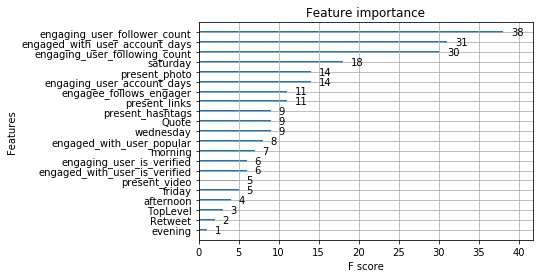

In [58]:
import matplotlib.pyplot as plt

data_dmatrix = xgb.DMatrix(data=X,label=Y)
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [100, 100]
plt.show()

Tal i com s'observa en el gràfic, les variables que el model ha considerat més rellevants a l'hora de fer la classificació són:
- el nombre d'usuaris que segueixen a la persona que reacciona al tuit.
- l'antiguitat del compte de twitter de la persona que publica el tuit.
- el nombre d'usuaris que la persona que publica el tuit segueix.
- si el tuit ha estat publicat un dissabte o no.
- si en el tuit hi consten fotografies o no.
- l'antiguitat del compte de twitter de la persona que reacciona al tuit.

<a id='Model_tokens'></a>
### 4.2 Model XGBoost amb Bert tokens

Per poder introduir el text dels tuits dins del model, primer cal processar els tokens de Bert, els quals ja venen donats a la taula de dades inicial. Els tokens per si sols no ens donen una representació numèrica de cada sub-paraula, relacionada amb la resta de sub-paraules. Per tant, es calculen embeddings de dimensió 768 per a cada token, obtinguts a partir de la resta de tokens. 

D'aquesta manera, s'obté una representació numèrica per a cada token d'un tuit. A continuació es mostren els embeddings obtinguts per als tokens del primer tuit.

In [65]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

# Define tokens as integers
df['text_tokens'] = df['text_tokens'].apply(lambda x: [int(i) for i in x])

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = TFBertModel.from_pretrained('bert-base-multilingual-cased')
input_ids = tf.constant(df.text_tokens[0])[None, :]  # Batch size 1
outputs = model(input_ids)
last_hidden_states = outputs[0]  # The last hidden-state is the first element of the output tuple

print(last_hidden_states)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


tf.Tensor(
[[[-0.11806291 -0.06662822 -0.23968297 ...  0.35775828  0.20738947
   -0.01426624]
  [-0.0231481  -0.3919716  -0.0081411  ...  0.3980926  -0.0536887
   -0.18542303]
  [ 0.08892918 -0.51991045  0.46351165 ...  0.4957789  -0.04179416
   -0.02178086]
  ...
  [-0.4809894  -0.5820069   0.20293285 ...  1.4162996   1.197582
    0.48669666]
  [ 0.11068164 -0.26170406  0.534588   ...  0.7309191   0.6119769
   -0.24543908]
  [-0.16927285 -0.38776207  0.22297058 ...  0.5162006   0.65443677
   -0.05803271]]], shape=(1, 63, 768), dtype=float32)


Tal i com es veu, el primer tuit consta de 63 tokens els quals s'ha obtingut una representació numèrica de 768 dimensions per a cada un. Tot i així, no es vol un embedding per a cada token, si no un embedding que representi el tuit sencer. Per tal d'aconseguir aquesta representació, es decideix calcular per a cada dimensió dels embeddings la mitjana per a tots els tokens d'un tuit, i d'aquesta manera es solapen els embeddings de cada token en un de sol.

A continuació es mostra la representació final que s'obté del primer tuit en un embedding de 768 dimensions.

In [60]:
#This would be the text token in 768 columns 
np.mean(last_hidden_states, axis=1)

array([[-0.3037722 , -0.28008264, -0.09138549, -0.06026363,  0.2342669 ,
         0.00469613, -0.06047177,  0.22428194, -0.06168656, -0.0739041 ,
         0.23068248,  0.1652006 ,  0.15185358,  0.19173081,  0.40846547,
        -0.21470375,  0.8920156 , -0.7387364 , -0.24538253, -0.07695821,
        -0.43823838, -0.25528646, -0.106215  ,  0.11741648, -0.0938615 ,
        -0.23657076, -0.7329467 ,  0.06430302,  0.02414657, -0.14366524,
         0.1553448 ,  0.36166552,  0.0283063 ,  0.21193108,  0.10733664,
         0.48893413, -0.05955479,  0.18234709,  0.34660035,  0.47206724,
         0.12521465,  0.35594055,  0.20305018, -0.32871398,  0.19125244,
        -0.11051668,  0.42089042, -0.13754708, -0.24724138,  0.09002645,
        -0.36177096, -0.3309563 ,  0.47241187,  0.20279345,  0.07397114,
        -0.18367882, -0.02973502, -0.18983237, -0.06383944, -0.14441885,
         0.48796946,  0.26548645,  0.11136573, -0.3480062 , -0.34210375,
        -0.25343323, -0.05702253, -0.358708  , -0.1

Per fer-ho amb la resta de tuits, es decideix iterar per a cada tuit, obtenir els embeddings per a cada token d'aquest tuit i calcular la mitjana dels embeddings per a cada token, de la següent manera:

In [ ]:
list_tokens = []
for index, row in df.iterrows():
    input_ids = tf.constant(row.text_tokens_int)[None, :]
    outputs = model(input_ids)
    last_hidden_states = outputs[0]
    last_hidden_states_numpy = last_hidden_states.numpy()
    mean_tokens = np.mean(last_hidden_states_numpy, axis=1)
    mean_tokens = mean_tokens.reshape(768)
    list_tokens.append(mean_tokens)
#d_tokens = pd.DataFrame(list_tokens)
#d_tokens.head()

No obstant, a l'hora d'intentar processar tots els tuits ens hem donat compte que no tenim els recursos computacionals necessaris per tal de poder calcular els embeddings. 

<a id='Conclusió'></a>
## 5.Conclusió